Link for the paper and the github code 

https://www.pnas.org/doi/pdf/10.1073/pnas.1918387117 

https://github.com/annaduncan/Kir_scripts/blob/master/lipid_prot_interaction_frequencies_v5.py


# Note-- For CDL2 use PO41 as selection

In [28]:
import sys
import re
import numpy as np
import time
import MDAnalysis
from MDAnalysis.analysis.distances import distance_array
import MDAnalysis.lib.NeighborSearch as NS
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import mdtraj as md
import ast
import argparse
from tqdm import tqdm
import re
import pandas as pd
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


In [29]:
def find_prot_residues(res_total, residue_list, nrepeats):
    '''res_total is the total number of residues in one repeat, residue list should be integers
     this function will find res IDs of all the repeats in the system, 
     and write selection string for them'''
    residue_dictionary = dict( zip(residue_list, [[] for i in residue_list]) )
    for residue in residue_list:
        for repeat in range(nrepeats):
            residue_dictionary[residue].append(int(residue) + repeat*res_total - 1) # the minus 1 is because residue indexes start at 0
    return residue_dictionary

In [30]:
def three_to_one(three_letter_code):
    '''converts any three letter amino acid code 
       to a one letter amino acid code '''
    mapping = {'Ala':'A',
               'Arg':'R',
               'Asn':'N',
               'Asp':'D',
               'Cys':'C',
               'Gln':'Q',
               'Glu':'E',
               'Gly':'G',
               'His':'H',
               'Ile':'I',
               'Leu':'L',
               'Lys':'K',
               'Met':'M',
               'Phe':'F',
               'Pro':'P',
               'Ser':'S',
               'Thr':'T',
               'Trp':'W',
               'Tyr':'Y',
               'Val':'V',}
    return mapping[three_letter_code[0].upper() 
                   + three_letter_code[1:].lower()]

In [31]:
def make_res_list(ref):
    u         = MDAnalysis.Universe(ref) 
    RES_Sel   = u.select_atoms('protein')
    res_lst   = list(RES_Sel.residues.resnames) 
    res_id    = list(RES_Sel.residues.resids) 
    
    protein_residue_list1 =[]
    
#     for name, ids in zip(res_lst,res_id): 
#         print (res_lst,res_id)
#         protein_residue_list.append(name+":"+str(ids))
        
    for i in range(0,len(res_lst)):
        xx=three_to_one(res_lst[i])
        #print (i,res_lst[i],xx)
        protein_residue_list1.append(xx+":"+str(i+1))
    return protein_residue_list1

In [32]:
def ProtLipidInteractions(ref,traj,
                      lipid_str   = 'POPC',
                      protein_centre_cutoff=60.0,
                      start_frame=0,end_frame=10,
                      stride=1):
    
    u                 = MDAnalysis.Universe(ref,traj)
    
    name1             = 'PO4'
    print ("There are {} frames in the trajectory".format(end_frame+1))
    
    #protein selection
    protein           = u.select_atoms('protein')
    protein_resids    = len(u.select_atoms("protein").residues.resids)
    protein_com       = np.array(u.residues.center_of_mass())
    Prot              = u.select_atoms('resid '+ str(0) + ':' + str(protein_resids))
    
    #selecting lipid coorrdinates   
    lipid             = u.select_atoms('resname %s'%lipid_str)
    Num_lipids        = len(u.select_atoms('resname %s and name %s' %(lipid_str,name1))) #or (sel.n_atoms)
    start             = lipid.resindices[0]+1
    end               = lipid.resindices[-1]+1
    n_lipid_beads     = len(u.select_atoms('resid %s'%start))
    Lipid             = u.select_atoms("resname %s and name %s"%(lipid_str,name1))   
    
    Prot_com          = Prot.center_of_mass(compound='residues')
       
    #print(Total_lipids,protein.n_atoms)
    #print(protein.positions)
    
    protein_residue_list = make_res_list(ref)
    
    print ("{} resids are {} {}".format(lipid_str, start, end))
    print ("There are %s %s's in the system."%(Num_lipids,lipid_str))
    print ("{} has {} beads per residue".format(lipid_str, n_lipid_beads))
    print ('started trajectory analysis...')
    
    arr   = []
    frames= []
    dist  = []
    
    print ("processing frames are- %s:%s:%s"%(start_frame,end_frame,stride))
    
    #calculating distances 
    for ts in u.trajectory[start_frame:end_frame:stride]:
        ns_prot   = NS.AtomNeighborSearch(Lipid)
        lpdi      = ns_prot.search(protein,protein_centre_cutoff, level='R')
        frames.append(ts.frame)
       
        # find lipids within 60 A of protein centroid and pick those out from lipids selection
        lipids_close_indices = []
        for i in range(len(lpdi)):
            lipids_close_indices.append(lpdi[i].resid)
            POS    = u.select_atoms("resid %s and name %s" %(lpdi[i].resid,name1))
            
            #print ("frames=",ts.frame,"Prot_com=",Prot_com,"lipid-ID=",lpdi[i].resid,"lip_pos=",POS.positions)
            
            temp_arr = distance_array(POS,Prot_com, box=u.dimensions) 
            arr.append(temp_arr.reshape(-1))
        nparr= np.stack(arr) 
        
        #print ("frames=",ts.frame,np.amin(nparr,axis=0),np.amin(nparr,axis=0).shape)
        
        x= np.array(np.amin(nparr,axis=0))
        x= np.reshape(x, (1,protein_resids)).flatten()
        
        for rec in x:
            dist.append(rec)
            
    return (frames,dist)

In [33]:
def count_frequncies(frames,dist,dist_cutoff=10.0):
    
       
    distances       = pd.DataFrame(dist)
    Traj_frames     = pd.DataFrame(frames)
    
    distances.columns=protein_residue_list 
    
    #print (distances)
    
    #counting protein-lipid interactions below a cutoff
    #print (np.asarray(dist).shape)
    dist[dist < dist_cutoff] = 1
    dist[dist > dist_cutoff] = 0
    print("cutoff distance",dist_cutoff)
    
    interactions =(dist) 
    #print (interactions.shape)
    proteinres_lipid_interactions  = np.array([0.0 for i in protein_residue_list])
    proteinres_lipid_interactions += np.sum(interactions, axis = 0)
    #print (proteinres_lipid_interactions,proteinres_lipid_interactions.shape,interactions.shape)
    #print (np.sum(interactions, axis = 0), np.sum(interactions, axis = 0).shape) 
    
    #The following lines writes the protein lipid distances, obtained at each frame into a csv file.
    distances.insert(0, value=Traj_frames.iloc[:,0], column='Frames') #inserting the frame into to the df
    distances.to_csv('Protein_'+lipid_selection+'_Distance.csv') #writing done
    
    proteinres_lipid_interactions_dict = dict( zip(protein_residue_list, proteinres_lipid_interactions) )
    
    #calculating percent interactions between protein and lipid
    
    percent_proteinres_lipid_interactions=(proteinres_lipid_interactions/len(n_frames)*100)
    percent_proteinres_lipid_interactions_dict = dict( zip(protein_residue_list, percent_proteinres_lipid_interactions) )
    
    return percent_proteinres_lipid_interactions_dict   

In [34]:
def plot_frequencies_fancy(protein_residue_list, 
                           proteinres_lipid_interactions_dict, 
                           cutoff_value=50.0,
                           lipid_str='POPC',
                           cutoff=True):
    
    d={}
    print ("lipid=",lipid_str)
    if cutoff:
        for (key,values) in proteinres_lipid_interactions_dict.items():
            if (values > (cutoff_value)) and (values < 99.0):
                d[key]=values
                #print (values)
    print ("There are %s protein residues interacting %s lipid within %s angs distance" \
           %(len(d),lipid_selection, dist_cutoff))
    print ("This interaction is above cutoff(%s)"%(cutoff_value))
   
    residue_list = d.keys() 
    ticks = range(len(d.keys()))
    
    if lipid_str=='CDL2':
        color='#00fa9a'
        
    elif lipid_str=='POPG':
        color='#8040bf'
        print ('color=',color,lipid_str)
        
    elif lipid_str=='POPE':
        color='#ff69b4'
        print ('color=',color,lipid_str)
        
    elif lipid_str=='POPC':
        color='#1e90ff'
        print ('color=',color,lipid_str)

    elif lipid_str=='CDL':
        color='#00fafa'
        print ('color=',color,lipid_str)    
    
    fig, ax = plt.subplots()
    ax.set_ylabel('Residues', fontsize=12)
    ax.set_xlabel('% of total {} contacts'.format(lipid_str), fontsize=14)
    ax.barh(ticks, d.values(), align='center',height=0.5,color=color)
    ax.invert_yaxis()
    ax.set_xlim(50,100)
    ax.set_yticks(ticks, labels=residue_list,rotation='horizontal', fontsize=14)
    plt.axis('tight')
    fig.set_size_inches(3.7,8.3)
    plt.savefig('Prot_{}_interaction.png'.format(lipid_str), orientation='portrait', 
                    bbox_inches='tight',dpi=600)
    plt.show()

/home/nyadav/anaconda3/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/nyadav/anaconda3/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/nyadav/anaconda3/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: R
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/nyadav/anaconda3/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: T
  warnings.warn("Failed to guess the mass for the following atom types: {}".for

number of frames process= 111
There are 16536 frames in the trajectory
POPG resids are 2989 3667
There are 362 POPG's in the system.
POPG has 12 beads per residue
started trajectory analysis...
processing frames are- 0:16535:150
cutoff distance 5.0
lipid= POPG
There are 52 protein residues interacting POPG lipid within 5.0 angs distance
This interaction is above cutoff(80.0)
color= #8040bf POPG


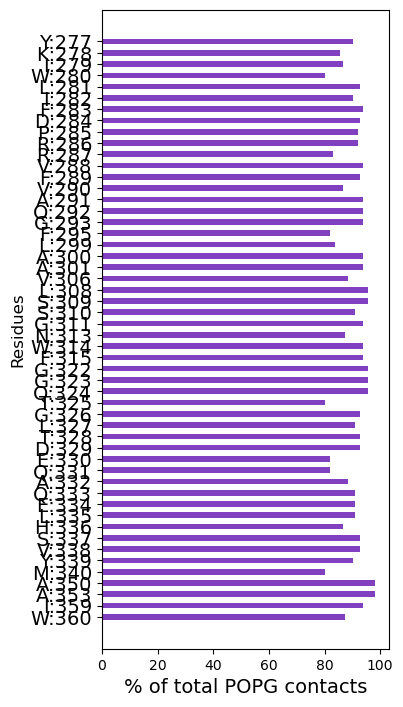

In [35]:
if __name__ == "__main__":
    
    ref               = "../LH1RC_RoseoDenit_CG_Run1_npt.gro"
    traj              = "../LH1RC_RoseoDenit_CG_Run1_prod.xtc"   

    u                 = MDAnalysis.Universe(ref,traj)
    
    start_f           = 0
    end_f             = len(u.trajectory)
    stride            = 150
    n_frames          = np.arange(start_f, end_f)[::stride]
    protein_centre_cutoff =70.0
    
    protein_residue_list  = make_res_list(ref)
    
    print ("number of frames process=",len(n_frames))
    #lipid selection
    #lipid_selection   = 'POPG'
    outfile           = 'prot.gro'
    
    
    dist_cutoff       = 5.0 #prot-lipid interaction distance cut-off    
    cutoff_value      = 80.0 #prot-lipid interacting above the Interaction_cutoff in the distance of dist_cutoff
    
    start_prot            = 274
    end_prot              = 364
    
    lipid_particles = {'headgroup' :{ 
                   'POPG' : ['PO4','GL0'],
                   'POPC' : ['PO4','NC3'],
                   'POPE' : ['PO4','NH3'],
                   'CDL2' : ['PO41','GL0']},
                'phosphate' : {
                    'POPG' : ['PO4'],
                    'POPC' : ['PO4'],
                    'POPE' : ['PO4'],
                    'CDL2' : ['PO41']},
                 'numbers' :{
                     'POPG' : ['298'],
                     'POPC' : ['207'],
                     'POPE' : ['273'],
                     'CDL2' : ['50']} }
    
    lip=['CDL2', 'POPG', 'POPC', 'POPE']
    
    #function call 
    

    lipid_selection= 'POPG'
    frames,dist = ProtLipidInteractions(ref,traj,
                                        lipid_str=lipid_selection,
                                        protein_centre_cutoff=protein_centre_cutoff,
                                        start_frame=start_f,end_frame=end_f,stride=stride)
    
    dist        = np.reshape(dist, (len(n_frames),len(protein_residue_list)))
        
    percent_proteinres_lipid_interactions_dict= count_frequncies(n_frames,dist,dist_cutoff=dist_cutoff)

    
    #enter the resids for intrested monomers in percent_proteinres_lipid_interactions_dict
    plot_frequencies_fancy(protein_residue_list, 
                           dict(list(percent_proteinres_lipid_interactions_dict.items())[274:364]), 
                           cutoff_value=cutoff_value,
                           lipid_str=lipid_selection,
                           cutoff=True)

    
    


In [36]:
lip=['CDL2', 'POPG', 'POPC', 'POPE']
dist=6.5
for i in range(0,len(lip)):
    name = ' '.join(str(x) for x in lipid_particles['phosphate'][lip[i]])
    num  = ' '.join(str(x) for x in lipid_particles['numbers'][lip[i]])
    print("resname %s and name %s"%(lip[i],name))
    #print("resname %s and number %s"%(lip[i],num))
    print("byres (resname %s and around %s protein)"%(lip[i],dist))

resname CDL2 and name PO41
byres (resname CDL2 and around 6.5 protein)
resname POPG and name PO4
byres (resname POPG and around 6.5 protein)
resname POPC and name PO4
byres (resname POPC and around 6.5 protein)
resname POPE and name PO4
byres (resname POPE and around 6.5 protein)
